##### Group 5

# General process
## 1. Analyse labels of images
### one image have several single labels
### extract all single labels and find :
####                all kind of labels can be divided into several categories：weather, land, other
#####                     one image could  exactly have one weather label
#####                     one image could have several land labels
#####                     one image could have several rarer labes(but bot common)
## 2. Build models
### one weather model
### several other models for each single labels.
## 3. Mark label to new images
### use models to predict labels for each image
### one new image label is composed of labels which are got from trained models
####          because if an image have cloudy label, it could not have other labels, we can stop predicting process
####          ......


In [1]:
import sys
import os
import subprocess
from six import string_types
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from skimage import io
from scipy import ndimage
from IPython.display import display
%matplotlib inline

In [2]:
PLANET_KAGGLE_ROOT = os.path.abspath("/Users/sunchenxi/Desktop/lab/kaggle/amazon/")
PLANET_KAGGLE_JPEG_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'train-jpg')
PLANET_KAGGLE_LABEL_CSV = os.path.join(PLANET_KAGGLE_ROOT, 'train_v2.csv')
assert os.path.exists(PLANET_KAGGLE_ROOT)
assert os.path.exists(PLANET_KAGGLE_JPEG_DIR)
assert os.path.exists(PLANET_KAGGLE_LABEL_CSV)

### label of train set

In [3]:
labels_df = pd.read_csv(PLANET_KAGGLE_LABEL_CSV)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


### single labels

In [5]:
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)
label_list,len(label_list)

(['haze',
  'primary',
  'agriculture',
  'clear',
  'water',
  'habitation',
  'road',
  'cultivation',
  'slash_burn',
  'cloudy',
  'partly_cloudy',
  'conventional_mine',
  'bare_ground',
  'artisinal_mine',
  'blooming',
  'selective_logging',
  'blow_down'],
 17)

### hot

In [6]:
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
labels_df.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


### co-ocurrence matrix
if one image have a cloudy label, it will not have other single labels

,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
haze,2697,2670,672,0,613,129,394,202,3,0,0,2,41,5,4,5,0
primary,2670,37513,11972,27668,7001,3469,7728,4455,209,0,7175,94,683,324,332,340,98
agriculture,672,11972,12315,9150,2712,2737,6034,3377,119,0,2493,24,225,38,32,65,22
clear,0,27668,9150,28431,5502,3090,6295,3527,173,0,0,70,747,307,311,308,85
water,613,7001,2712,5502,7411,915,2125,868,24,0,1295,26,206,299,16,49,3
habitation,129,3469,2737,3090,915,3660,2786,895,41,0,441,36,163,29,4,13,3
road,394,7728,6034,6295,2125,2786,8071,1294,36,0,1382,59,323,110,10,151,2
cultivation,202,4455,3377,3527,868,895,1294,4477,126,0,748,4,89,18,35,58,8
slash_burn,3,209,119,173,24,41,36,126,209,0,33,0,10,0,2,2,2
cloudy,0,0,0,0,0,0,0,0,0,2089,0,0,0,0,0,0,0


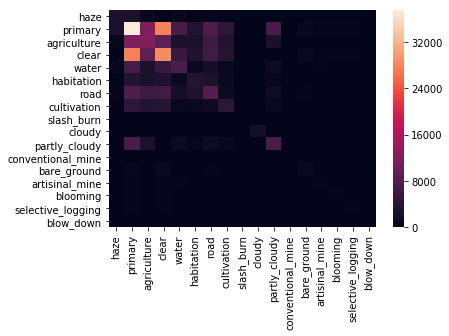

In [7]:
def make_cooccurence_matrix(labels):
    numeric_df = labels_df[labels]; 
    c_matrix = numeric_df.T.dot(numeric_df) #转置后点积变成17*17
    sns.heatmap(c_matrix) #热力图
    return c_matrix
    
make_cooccurence_matrix(label_list)

### weather labels
#### Each image should have exactly one weather label
#### diagonal matrix

,clear,partly_cloudy,haze,cloudy
clear,28431,0,0,0
partly_cloudy,0,7261,0,0
haze,0,0,2697,0
cloudy,0,0,0,2089


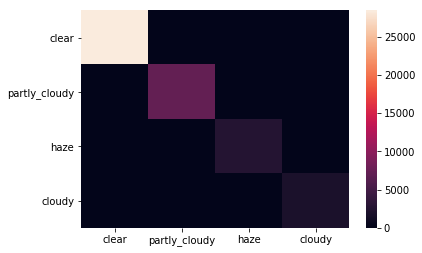

In [9]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
make_cooccurence_matrix(weather_labels)

### land labels
one image could have several different land labels

,primary,agriculture,water,cultivation,habitation,road
primary,37513,11972,7001,4455,3469,7728
agriculture,11972,12315,2712,3377,2737,6034
water,7001,2712,7411,868,915,2125
cultivation,4455,3377,868,4477,895,1294
habitation,3469,2737,915,895,3660,2786
road,7728,6034,2125,1294,2786,8071


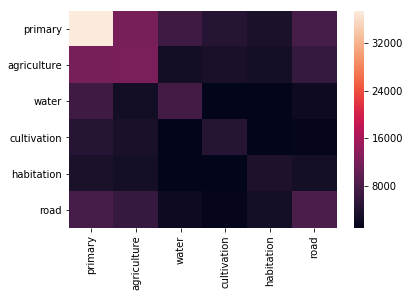

In [10]:
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation','road']
make_cooccurence_matrix(land_labels)

### other labels （rarer labels ）
same as land labels
but have very little overlap

,slash_burn,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
slash_burn,209,0,10,0,2,2,2
conventional_mine,0,100,10,4,0,0,0
bare_ground,10,10,862,40,3,13,4
artisinal_mine,0,4,40,339,0,6,0
blooming,2,0,3,0,332,7,1
selective_logging,2,0,13,6,7,340,1
blow_down,2,0,4,0,1,1,98


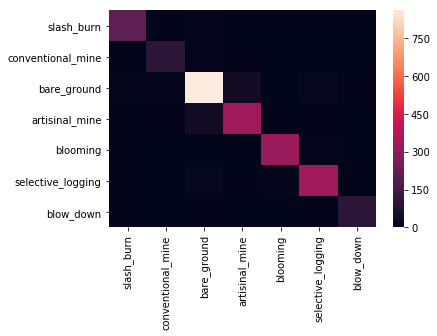

In [12]:
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
make_cooccurence_matrix(rare_labels)